#### Importing Functions

In [1]:
from utils import *

#### Importing the libraries

In [2]:
import cv2
import os
import tifffile # for reading tiff files. There are other modules that can do this, but tifffile is most stable on Windows
import numpy as np # for array handling
import matplotlib.pyplot as plt # for QC
import glob # to gather up image filepath lists
import rasterio
from rasterio.plot import show
import scipy # same
import imagecodecs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from skimage.transform import resize
from skimage.util import random_noise
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

## Available data


There are the folders:
- scenes
- masks
- val --> masks


The scenes folder includes Sentinel-2 imagery with 3 bands (also called channels in DL-jargon (B3-B4-B8). The mask contains vaule 0 for ocean and value 1 for ice sheet.

In [3]:
training_file_path = 'D:/EAGLE_Deep_Learning/Deep-Learning-Final-Project-SS-2023/Data/scenes/*.tif'
testing_file_path = 'D:/EAGLE_Deep_Learning/Deep-Learning-Final-Project-SS-2023/Data/val/*.tif'

In [4]:
top_train_list = read_data(training_file_path)

In [5]:
#Available validation scenes
top_test_list = read_data(testing_file_path)

#### Plotting the first band of a training image for testing

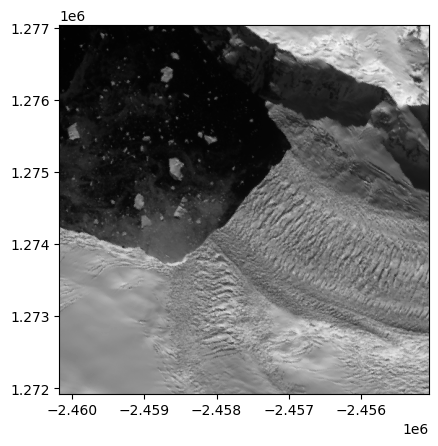

In [6]:
src = rasterio.open("D:\EAGLE_Deep_Learning\Deep-Learning-Final-Project-SS-2023\Data\scenes\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-1.tif")
img0 = show(src.read(1),transform=src.transform, cmap='gray')

----- Make our data DL ready -----

In [7]:
#creating empty arrays to store our data
imgResize = 512
channels = 3
train_dir, test_dir = create_arrays(512, 3)

In [8]:
resized_training_images = resize_images(imgResize, channels, top_train_list, train_dir)
resized_testing_images = resize_images(imgResize, channels, top_test_list, test_dir)

----- Processing the labels ------

In [9]:
train_mask_path = "D:\EAGLE_Deep_Learning\Deep-Learning-Final-Project-SS-2023\Data\masks\*.tif"

label_train_list = read_data(train_mask_path)
# print(label_train_list)

In [10]:
# BUG FIX
testing_mask_path = 'D:\EAGLE_Deep_Learning\Deep-Learning-Final-Project-SS-2023\masks\*.tif'

label_test_list = read_data(testing_mask_path)
# print(label_test_list)

#### Plotting one of the training labels as an example

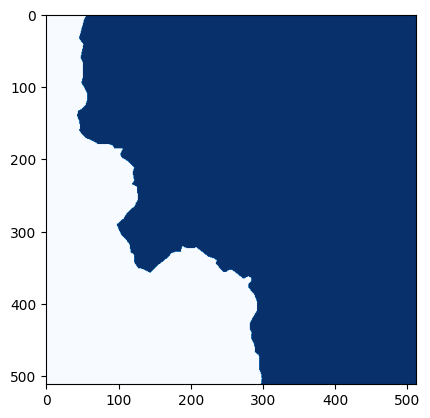

In [11]:
#Lets have a look at our labels
plot_label(label_train_list, 7)



Let's start reshaping our labels.

In [12]:
# Define the directory where you want to save the individual label images
label_save_dir_train = './train_label_images/'
label_save_dir_test = './test_label_images/'

# Using the function create_dir to create file directories for saving labelled images for training and testing
create_dir(label_save_dir_train)
create_dir(label_save_dir_test)

In [87]:
# def label_list_to_array(label_list, image_resize_value, size):
#     label_train_total = np.zeros((len(label_train_list), imgResize, imgResize, 3))
#     for i in range(len(label_train_list)):
#         img = tifffile.imread(label_train_list[i])
#         #again in our case resizing is not necessary but reshaping
#         img_reshaped = resize(img, (imgResize, imgResize, 1))
#         label_train_total[i] = img_reshaped
#     return label_train_total

In [15]:
label_train_total = label_list_to_array(label_train_list, imgResize, 3)

In [17]:
label_test_total = label_list_to_array(label_test_list, imgResize, 3)


In [18]:
onehot_label_train_total = onehot_label(label_train_total, label_train_list, imgResize, 2)

In [19]:
onehot_label_test_total = onehot_label(label_test_total, label_test_list, imgResize, 2)

Checking how one-hot-encoded labels look like

[0. 1.]


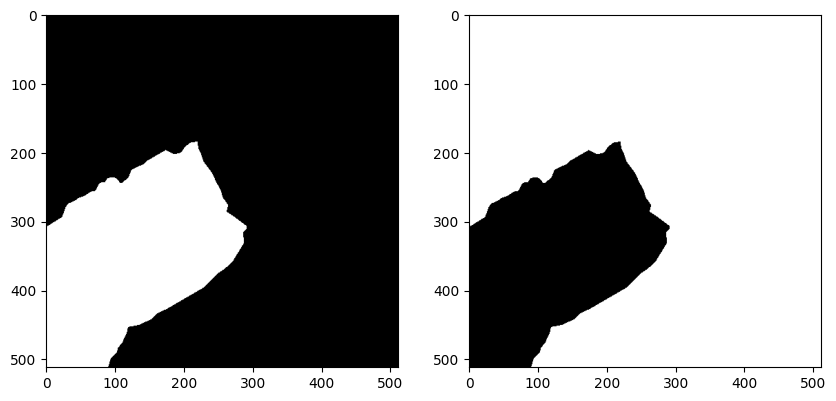

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(onehot_label_test_total[2,:,:,0], cmap='gray')
axes[1].imshow(onehot_label_test_total[2,:,:,1], cmap='gray')
print(np.unique(onehot_label_train_total))

Great, this is looking good. Finally, we save our labels for part 2

In [21]:
np.save('D:/EAGLE_Deep_Learning/Deep-Learning-Final-Project-SS-2023/Scripts/train_label_images/label_train.npy', onehot_label_train_total)
np.save('D:/EAGLE_Deep_Learning/Deep-Learning-Final-Project-SS-2023/Scripts/test_label_images/label_test.npy', onehot_label_test_total)

## Training the Neural Network

This Tutorial was created by C. Baumhoer and is based on work from https://github.com/mmorphew/unet_remote_sensing & https://github.com/karolzak/keras-unet


----- read in the data ------

In [24]:
# Load and convert train and testing data into arrays
data_files_train = np.sort(label_train_total)
data_files_test = np.sort(label_test_total)

We need to tell Tensorflow the size of our input image. This will depend on how we resized the images during preprocessing.

In [25]:
nx = 512
ny = 512

To improve learning, let's standardize globally by subtracting the mean and dividing by the standard deviation.

In [26]:
data_scaled = standardize_data(data_files_train)
data_test_scaled = standardize_data(data_files_test)

In [27]:
x = data_scaled
y = onehot_label_train_total[:,:,:] # exclude clutter
x_test = data_test_scaled
y_test = onehot_label_test_total[:,:,:]

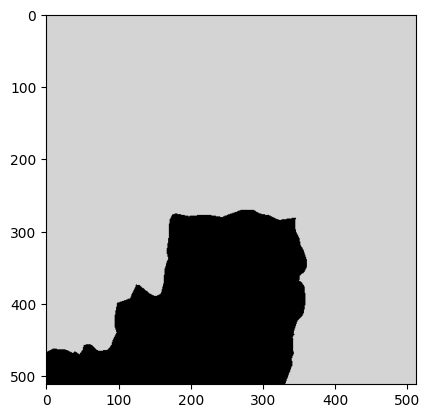

In [28]:
# Plot a random image to see if everything looks alright
plt.imshow(x[15])

Now that we have our data and labels as we want them, we can split our dataset into a portion for training and a portion for validation.

In [29]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=1234)

We can further augment our training data by introducing data augmentations where we flip the images in various ways, add noise, etc.

In [22]:
# Data augmentation on just the training data
## Image Augmentation
# Vertical Image
Vx = [np.flip(x, axis=1) for x in x_train]
Vy = [np.flip(x, axis=1) for x in y_train]

# Horizontal Image
Hx = [np.flip(x, axis=2) for x in x_train]
Hy = [np.flip(x, axis=2) for x in y_train]

# Horizontal Vertical Image
HVx = [np.flip(x, axis=2) for x in Vx]
HVy = [np.flip(x, axis=2) for x in Vy]

# Appending the augmented image and mask to the main dataset.
x_train = np.append(x_train, Vx, axis=0)
y_train = np.append(y_train, Vy, axis=0)

x_train = np.append(x_train, Hx, axis=0)
y_train = np.append(y_train, Hy, axis=0)

x_train = np.append(x_train, HVx, axis=0)
y_train = np.append(y_train, HVy, axis=0)


NameError: name 'x_train' is not defined

Let's create a model object, compile it, and summarize it so we can make sure the layers were built the way we wanted them to be built by Keras. We'll also define our optimizer, Adam, and pick a loss function and tracking metrics.

In [30]:
model = satellite_unet(input_shape=(512, 512, 3), num_classes=2, output_activation='sigmoid', num_layers=3 )
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["categorical_accuracy", f1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 512, 512, 64)         36928     ['batch_normalization[0][0

----- 

Callbacks for instructing Tensorflow on how to behave during training. 

In [28]:
#Let's save our model checkpoints relative to epoch and loss
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

In [29]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=30, min_lr=0.00001, verbose=1),
    ModelCheckpoint(checkpoint_filepath, monitor='val_categorical_accuracy',
    mode='max',verbose=1, save_best_only=True, save_weights_only=True)
]

Now let's train our model!

In [82]:
results = model.fit(x_train, y_train, batch_size= 4, epochs=20, callbacks=callbacks,
                   validation_data=(x_val, y_val))

Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 0.1991 - categorical_accuracy: 0.9200 - f1: 0.9128 
Epoch 1: val_categorical_accuracy improved from -inf to 0.99770, saving model to weights.01-0.01.h5
15/15 [==============================] - 306s 20s/step - loss: 0.1991 - categorical_accuracy: 0.9200 - f1: 0.9128 - val_loss: 0.0061 - val_categorical_accuracy: 0.9977 - val_f1: 0.9954 - lr: 0.0010
Epoch 2/20
15/15 [==============================] - ETA: 0s - loss: 0.0179 - categorical_accuracy: 0.9959 - f1: 0.9941 
Epoch 2: val_categorical_accuracy improved from 0.99770 to 0.99820, saving model to weights.02-0.01.h5
15/15 [==============================] - 298s 20s/step - loss: 0.0179 - categorical_accuracy: 0.9959 - f1: 0.9941 - val_loss: 0.0067 - val_categorical_accuracy: 0.9982 - val_f1: 0.9932 - lr: 0.0010
Epoch 3/20
15/15 [==============================] - ETA: 0s - loss: 0.0169 - categorical_accuracy: 0.9953 - f1: 0.9932 
Epoch 3: val_categorical_accuracy did not

------ Check Accuracy -------

NameError: name 'results' is not defined

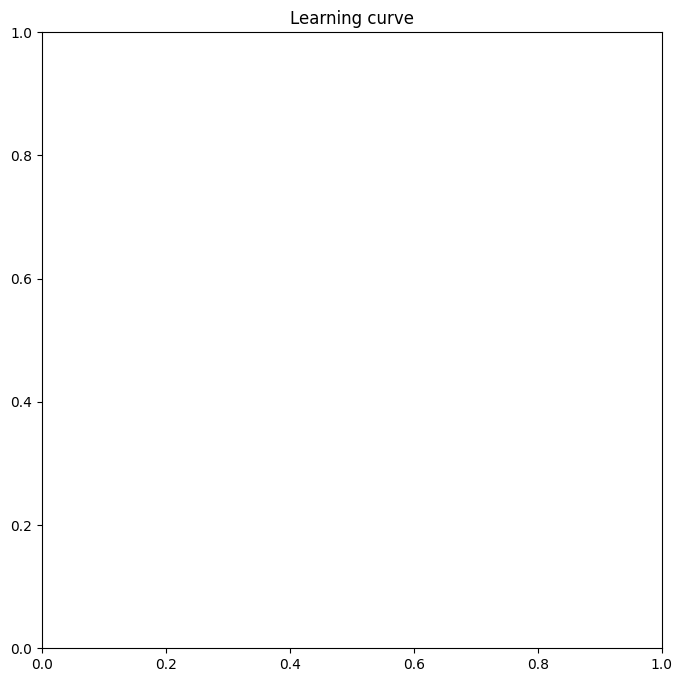

In [30]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(results.history["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.plot(results.history["categorical_accuracy"], label="categorical_accuracy")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

-------- Evaluate the trained weights and predict -------

In [84]:
# Load best model
# Have a look at all saved models and take the one with the highest epoch value
model.load_weights('D:\EAGLE_Deep_Learning\Deep-Learning-Final-Project-SS-2023\Scripts\weights.20-0.00.h5')

In [85]:
# Evaluate on test set
eval = model.evaluate(x_test, y_test)
print('Test loss:', eval[0])
print('Test accuracy:', eval[1])

1/1 [==============================] - 5s 5s/step - loss: 2.2385 - categorical_accuracy: 0.3710 - f1: 0.3819
Test loss: 2.2385127544403076
Test accuracy: 0.37096086144447327


In [86]:
# Predict on train, val and test
preds_train = model.predict(x_train[0:10], verbose=1)
preds_val = model.predict(x_val, verbose=1)
preds_test = model.predict(x_test, verbose=1)

1/1 [==============================] - 8s 8s/step


In [87]:
# Threshold prediction probabilities
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

--------- Plot Results --------

In [34]:
# Let's see how a prediction on the training data looks like
plot_sample_all(x_train, y_train, preds_train, preds_train_t, ix=9, filename='test.png')

NameError: name 'plot_sample_all' is not defined

This looks really good. What's about our test data?

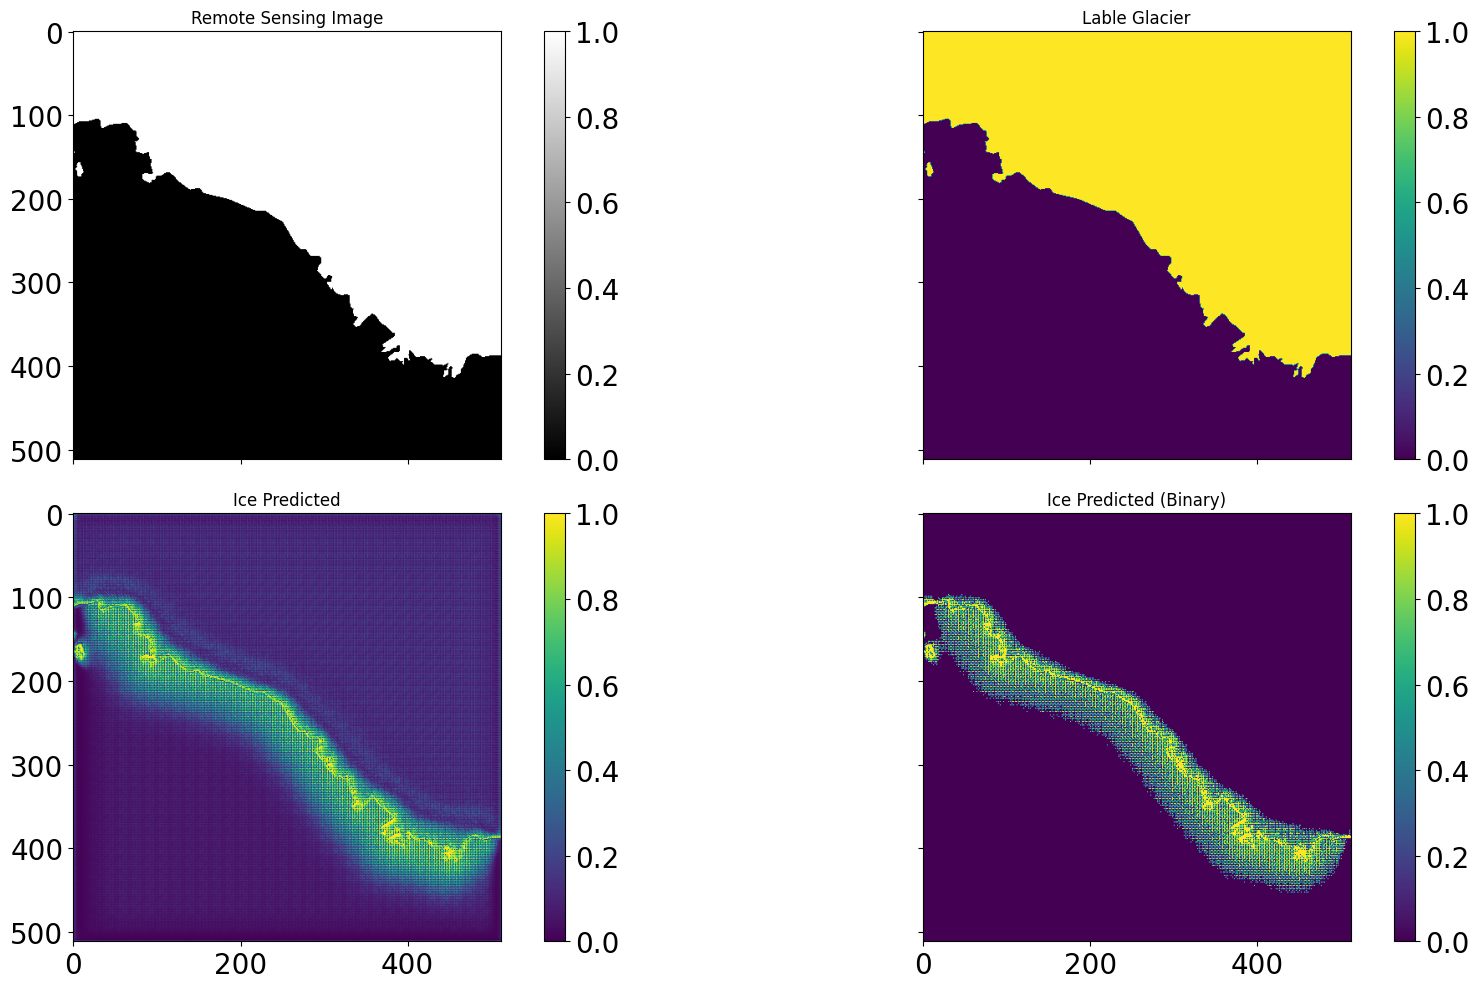

In [91]:
# Check if test data looks all right
plot_sample(x_test, y_test, preds_test, preds_test_t, ix=1)

That looks not as good....Well, we only trained on very little data and would need more training data for sophisticated results!

-------- Accuracy Metrics -------

In [92]:
x_total = np.concatenate((x_train, x_val, x_test), axis=0)
y_total = np.concatenate((y_train, y_val, y_test), axis=0)
pred_total = np.concatenate((preds_train_t, preds_val_t, preds_test_t), axis=0)

In [94]:
print_roc_metrics(y_val, preds_val_t)

Confusion matrix:
[[1047499    1077]
 [     22 1048554]]
F1 score: 0.9995
Recall score: 1.0000
Precision score: 0.9990
